In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import os
import seaborn as sns
from jax import vmap


# Binary FA

Notes:

max_iteration : decides the no. of times the e-step and m-step is calculted so that it converges to a solution. Most of the time it takes approx a mean of max_iteration of 3.6 (Pg : 665)

(2 * y - 1) converts True => 1 and False => -1



In [89]:

class BinaryFA:
    def __init__(self, input_dim, latent, max_iter=3, conv_tol=1e-4, compute_ll=True):
        self.W = 0.1 * np.random.randn(latent, input_dim)  # 2x16
        self.b = 0.01 * np.random.randn(input_dim, 1)  # 16x1
        self.mu_prior = np.zeros((latent, 1))  # 2x1
        self.sigma_prior = np.eye(latent)  # 2x2
        self.input_dim = input_dim
        self.latent = latent
        self.max_iter = max_iter
        self.compute_ll = compute_ll
        if compute_ll:
            self.ll_hist = np.zeros((max_iter + 1, 1))  # 51x1

    def variational_em(self, data):
        ll_hist = np.zeros((self.max_iter, 1))
        i = 0
        while i < self.max_iter:
            S1, S2, ll = self.estep(data)
            ll_hist[i, 0] = ll
            self.mstep(S1, S2)
            if i != 0:
                delta_fval = abs(ll_hist[i] - ll_hist[i - 1])
                avg_fval = (abs(ll_hist[i]) + abs(ll_hist[i - 1]) + np.finfo(float).eps) / 2
                if (delta_fval / avg_fval) < conv_tol:
                    break
            i += 1
        return ll_hist[:i]

    def estep(self, data):
        S1 = np.zeros((self.latent + 1, self.input_dim))  # 3x16
        S2 = np.zeros((self.latent + 1, self.latent + 1, self.input_dim))  # 3x3x16
        W, b, mu_prior = self.W, self.b, self.mu_prior
        ll = 0
        for i in range(data.T.shape[1]):
            mu_post, sigma_post, logZ, lambd = self.compute_latent_posterior_statistics(data.T[:, i], max_iter=3, logs=False if i != 0 else True)
            ll += logZ
            EZZ = np.zeros((self.latent + 1, self.latent + 1))
            EZZ[: self.latent, : self.latent] = sigma_post + np.outer(mu_post, mu_post)
            EZZ[self.latent, : self.latent] = mu_post.T
            EZZ[: self.latent, self.latent] = np.squeeze(np.asarray(mu_post))
            EZZ[self.latent, self.latent] = 1
            EZ = np.append(mu_post, np.ones((1, 1)))
            for j in range(self.input_dim):
                S1[:, j] = S1[:, j] + (data.T[j, i] - 0.5) * EZ
                S2[:, :, j] = S2[:, :, j] - 2 * lambd[j] * EZZ
        return S1, S2, ll

    def mstep(self, S1, S2):
        for i in range(self.input_dim):
            what = np.linalg.lstsq(S2[:, :, i], S1[:, i])[0]
            self.W[:, i] = what[: self.latent]
            self.b[i] = what[self.latent]

    def compute_latent_posterior_statistics(self, y, output=[0, 0, 0, 0], max_iter=3, logs = False):
        W, b = np.copy(self.W), np.copy(self.b)
        y = y.reshape((-1, 1))
        # variational parameters
        mu_prior = self.mu_prior
        xi = (2 * y - 1) * (W.T @ mu_prior + b)
        if logs : 
            print(f'{xi[1]}, ==> {(W.T @ mu_prior + b)[1]}')
        xi[xi == 0] = 0.01 * np.random.rand(np.count_nonzero(xi == 0))  # 16x1
        sigma_inv, iter = np.linalg.inv(self.sigma_prior), 0
        if logs : 
            print(f'Here : {sigma_inv}')
        for iter in range(max_iter):
            lambd = (0.5 - sigmoid(xi)) / (2 * xi)
            tmp1 = W @ np.diagflat(lambd) @ W.T  # 2x2
            # C^-1 ==> sigma_post covariance matrix of posterior
            sigma_post = np.linalg.inv(sigma_inv - (2 * tmp1))
            if print and iter == 0:
                # print(f'Sigmoid : {sigmoid(xi)}, lambda : {lambd}, tmp1 : {tmp1}, sigma_post : {sigma_post}, tmp3 : {tmp3}, tmp2 : {tmp2}, tmp4 : {tmp4}, mu_post : {mu_post}')
                print(f'sigma_post : {sigma_post}, sigma_inv : {sigma_inv} ==> {sigma_inv - (2 * tmp1)} ==> {tmp1}')
            tmp3 = y - 0.5 + 2 * lambd * b
            tmp2 = np.sum(W @ np.diagflat(tmp3), axis=1).reshape((2, 1))
            mu_post = sigma_post @ (sigma_inv @ mu_prior + tmp2)

            tmp = np.diag(W.T @ (sigma_post + mu_post @ mu_post.T) @ W)
            tmp = tmp.reshape((tmp.shape[0], 1))
            tmp4 = 2 * (W @ np.diagflat(b)).T @ mu_post
            xi = np.sqrt(tmp + tmp4 + b**2)
            logZ = 0
            if self.compute_ll:
                lam = -lambd
                A = np.diagflat(2 * lam)
                # A^-1 = diag(1/lamba)
                invA = np.diagflat(1 / (2 * lam))
                bb = -0.5 * np.ones((y.shape[0], 1))
                # log |C| = (D-L) log sigma^2 + sumation(from 1 to L var j for log lamda j)
                c = -lam * xi**2 - 0.5 * xi + np.log(1 + np.exp(xi))
                ytilde = invA @ (bb + y)
                B = W.T
                logconst1 = -0.5 * np.sum(np.log(lam / np.pi))
                logconst2 = 0.5 * ytilde.T @ A @ ytilde - np.sum(c)
                gauss = multivariate_normal.logpdf(
                    np.squeeze(np.asarray(ytilde)),
                    mean=np.squeeze(np.asarray(B @ mu_prior + b)),
                    cov=(invA + B @ sigma_post @ B.T),
                )
                logZ = logconst1 + logconst2 + gauss
                output = [mu_post, sigma_post, logZ, lambd]
        return output

    def predict_missing(self, y):
        N, T = y.shape  # 150 x 16
        prob_on = np.zeros(y.shape)  # 150 x 16
        post_pred = np.zeros((N, T, 2))  # 150 x 16 x 2
        L, p = self.W.shape  # 16 x 3
        B = np.c_[np.copy(self.b), self.W.T]  # 16 x 3
        for n in range(N):
            mu_post, sigma_post, logZ, lambd = self.compute_latent_posterior_statistics(y[n, :].T, False)
            mu1 = np.r_[np.ones((1, 1)), mu_post]
            sigma1 = np.zeros((L + 1, L + 1))
            sigma1[1:, 1:] = sigma_post
            prob_on[n, :] = sigmoid_times_gauss(B, mu1, sigma1)

        return prob_on

    def infer_latent(self, y):
        N, T = y.shape
        W, b, mu_prior = self.W, self.b, self.mu_prior
        K, T2 = self.W.shape
        mu_post, loglik = np.zeros((K, N)), np.zeros((1, N))
        sigma_post = np.zeros((K, K, N))
        for n in range(N):
            mu_p, sigma_p, loglik[0, n], _ = self.compute_latent_posterior_statistics(y[n, :].T)
            mu_post[:, n] = np.squeeze(np.asarray(mu_p))
            sigma_post[:, :, n] = np.squeeze(np.asarray(sigma_p))
        return mu_post, sigma_post, loglik


def sigmoid_times_gauss(X, wMAP, C):
    vv = lambda x, y: jnp.vdot(x, y)
    mv = vmap(vv, (None, 0), 0)
    mm = vmap(mv, (0, None), 0)
    vm = vmap(vv, (0, 0), 0)

    mu = X @ wMAP
    n = X.shape[1]
    if n < 1000:
        sigma2 = np.diag(X @ C @ X.T)
    else:
        sigma2 = vm(X, mm(C, X))
    kappa = 1 / np.sqrt(1 + np.pi * sigma2 / 8)
    p = sigmoid(kappa * mu.reshape(kappa.shape))
    return p



In [90]:
os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "figures"

# Input created


In [91]:
np.random.seed(1)

max_iter, conv_tol = 50, 1e-4
sigmoid = lambda x: 1 / (1 + np.exp(-1 * x))
d, k, m = 16, 3, 50 # Here m is tile height, k is no. of vectors used, d is no. of bits used
noise_level = 0.5

proto = np.random.rand(d, k) < noise_level

# src = np.concatenate((np.tile(proto[:, 0], (1, m)), np.tile(proto[:, 1], (1, m)), np.tile(proto[:, 2], (1, m))), axis=1)
clean_data = np.concatenate(
    (np.tile(proto[:, 0], (m, 1)), np.tile(proto[:, 1], (m, 1)), np.tile(proto[:, 2], (m, 1))), axis=0
)
# plt.figure()
# ax = plt.gca()
# plt.imshow(clean_data, aspect="auto", interpolation="none", origin="lower", cmap="gray")
# plt.title("Noisy Binary Data")
# plt.show()

# print(clean_data.T.shape)

# Added noise to the input 

Here the noise kept is 5% overall

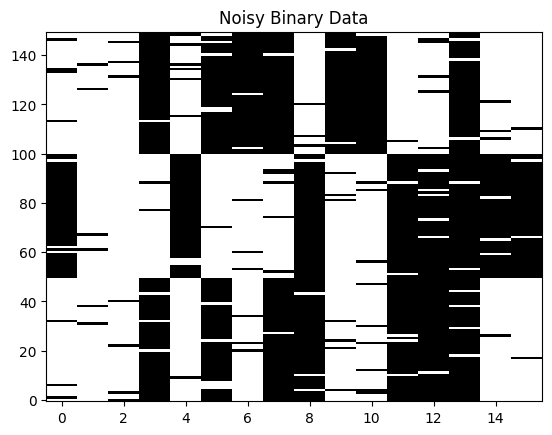

In [92]:
n = clean_data.shape[0]
noise_percent = 0.05
mask, noisy_data, missing_data, = (
    np.random.rand(n, d) < noise_percent,
    np.copy(clean_data),
    np.copy(clean_data),
)

noisy_data[mask] = 1 - noisy_data[mask]
missing_data[mask] = np.nan

plt.figure()
ax = plt.gca()
plt.imshow(noisy_data, aspect="auto", interpolation="none", origin="lower", cmap="gray")
plt.title("Noisy Binary Data")
plt.show()

In [93]:
MARKER_SIZE = 2
max_iter = 4
binaryFA = BinaryFA(d, 2, max_iter, 1e-4, True)
binaryFA.variational_em(noisy_data)

# mu_post, sigma_post, loglik = binaryFA.infer_latent(noisy_data)

# symbols = ["ro", "gs", "k*"]
# plt.figure()
# plt.plot(mu_post[0, :m], mu_post[1, 0:m], symbols[0], markersize=MARKER_SIZE)
# plt.plot(mu_post[0, m : 2 * m], mu_post[1, m : 2 * m], symbols[1], markersize=MARKER_SIZE)
# plt.plot(mu_post[0, 2 * m :], mu_post[1, 2 * m :], symbols[2], markersize=MARKER_SIZE)
# plt.title("Latent Embedding")
# sns.despine()
# plt.show()

[-0.00660908], ==> [-0.00660908]
Here : [[1. 0.]
 [0. 1.]]
sigma_post : [[ 0.95245399 -0.01124676]
 [-0.01124676  0.96071654]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.05006463 0.01229272]
 [0.01229272 1.04103366]] ==> [[-0.02503232 -0.00614636]
 [-0.00614636 -0.02051683]]
sigma_post : [[ 0.95245399 -0.01124676]
 [-0.01124676  0.96071654]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.05006463 0.01229272]
 [0.01229272 1.04103366]] ==> [[-0.02503232 -0.00614636]
 [-0.00614636 -0.02051683]]
sigma_post : [[ 0.95245399 -0.01124676]
 [-0.01124676  0.96071654]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.05006463 0.01229272]
 [0.01229272 1.04103366]] ==> [[-0.02503232 -0.00614636]
 [-0.00614636 -0.02051683]]
sigma_post : [[ 0.95245399 -0.01124676]
 [-0.01124676  0.96071654]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.05006463 0.01229272]
 [0.01229272 1.04103366]] ==> [[-0.02503232 -0.00614636]
 [-0.00614636 -0.02051683]]
sigma_post : [[ 0.95245399 -0.01124676]
 [-0.01124676  0.96071654]], sigma_inv : [[1.

/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_3218/1874325461.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ll_hist[i, 0] = ll
/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_3218/1874325461.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  what = np.linalg.lstsq(S2[:, :, i], S1[:, i])[0]


sigma_post : [[ 0.82110405 -0.08204381]
 [-0.08204381  0.95891663]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.22837375 0.10509826]
 [0.10509826 1.05183561]] ==> [[-0.11418688 -0.05254913]
 [-0.05254913 -0.0259178 ]]
sigma_post : [[ 0.82110405 -0.08204381]
 [-0.08204381  0.95891663]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.22837375 0.10509826]
 [0.10509826 1.05183561]] ==> [[-0.11418688 -0.05254913]
 [-0.05254913 -0.0259178 ]]
sigma_post : [[ 0.82110405 -0.08204381]
 [-0.08204381  0.95891663]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.22837375 0.10509826]
 [0.10509826 1.05183561]] ==> [[-0.11418688 -0.05254913]
 [-0.05254913 -0.0259178 ]]
sigma_post : [[ 0.82110405 -0.08204381]
 [-0.08204381  0.95891663]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.22837375 0.10509826]
 [0.10509826 1.05183561]] ==> [[-0.11418688 -0.05254913]
 [-0.05254913 -0.0259178 ]]
sigma_post : [[ 0.82110405 -0.08204381]
 [-0.08204381  0.95891663]], sigma_inv : [[1. 0.]
 [0. 1.]] ==> [[1.22837375 0.10509826]
 [0.10509826 1.

array([[-1666.15543703],
       [-1302.3958163 ],
       [-1163.5790586 ],
       [-1138.53741925]])

W
[[ 0.00647174  0.05569989 -0.01317056  0.21723328  0.11770702  0.16400574
  -0.04178706 -0.08968796 -0.10702883 -0.01137816 -0.12583499 -0.06337921
  -0.04307697  0.09442847 -0.04728756 -0.14070641]
 [-0.04474733  0.01885829  0.05609181 -0.09216591  0.06473751  0.13868256
   0.04895166  0.02387959 -0.04481118 -0.0610795  -0.20299451  0.06079466
  -0.03541089  0.01525815  0.05012748 -0.07864028]]
b
[[ 0.01016996]
 [ 0.00113111]
 [ 0.01496995]
 [ 0.00168938]
 [ 0.00318625]
 [-0.00273377]
 [ 0.01476414]
 [-0.02103493]
 [-0.00532832]
 [-0.00305054]
 [-0.01530421]
 [-0.00794703]
 [-0.02172123]
 [ 0.00190387]
 [-0.01405228]
 [ 0.0036986 ]]
mu_prior
[[0.]
 [0.]]
W
[[-0.26747481  0.01263364  0.01387831  0.29292621 -0.21170381  0.2873957
   0.14503804  0.24565274 -0.18584565  0.15417328  0.14942305 -0.17889543
  -0.14943638  0.00784433 -0.26782685 -0.29155516]
 [ 0.0048168   0.0068721   0.00390453 -0.04897245  0.03442405  0.01162992
  -0.09963537 -0.02339421  0.0974972  -0.12413629 -0.1554710

/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_1302/1910079842.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ll_hist[i, 0] = ll
/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_1302/1910079842.py:56: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  what = np.linalg.lstsq(S2[:, :, i], S1[:, i])[0]
/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_1302/1910079842.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performin

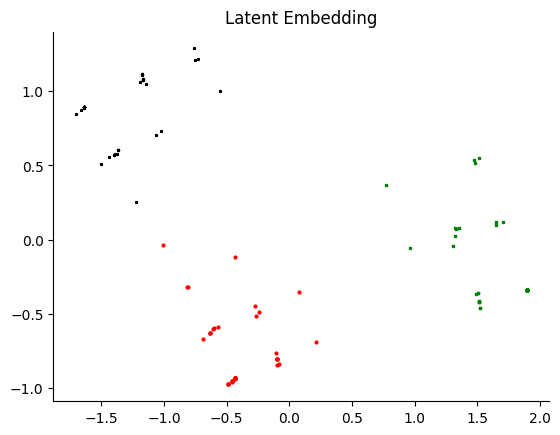

In [85]:
MARKER_SIZE = 2
binaryFA = BinaryFA(d, 2, 3, 1e-4, True)
binaryFA.variational_em(noisy_data)

mu_post, sigma_post, loglik = binaryFA.infer_latent(noisy_data)

symbols = ["ro", "gs", "k*"]
plt.figure()
plt.plot(mu_post[0, :m], mu_post[1, 0:m], symbols[0], markersize=MARKER_SIZE)
plt.plot(mu_post[0, m : 2 * m], mu_post[1, m : 2 * m], symbols[1], markersize=MARKER_SIZE)
plt.plot(mu_post[0, 2 * m :], mu_post[1, 2 * m :], symbols[2], markersize=MARKER_SIZE)
plt.title("Latent Embedding")
sns.despine()
plt.show()

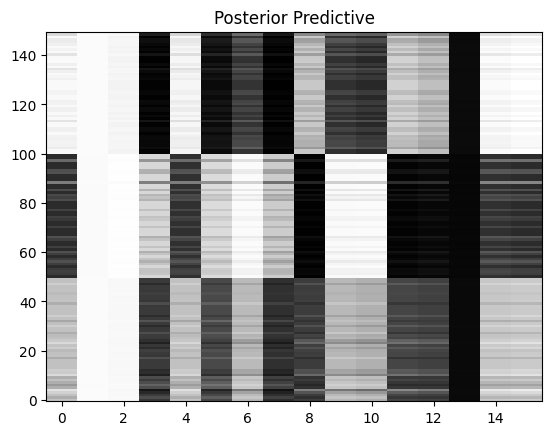

In [64]:
prob_on = binaryFA.predict_missing(noisy_data)
plt.figure()
plt.imshow(prob_on, aspect="auto", interpolation="none", origin="lower", cmap="gray")
plt.title("Posterior Predictive")
plt.show()

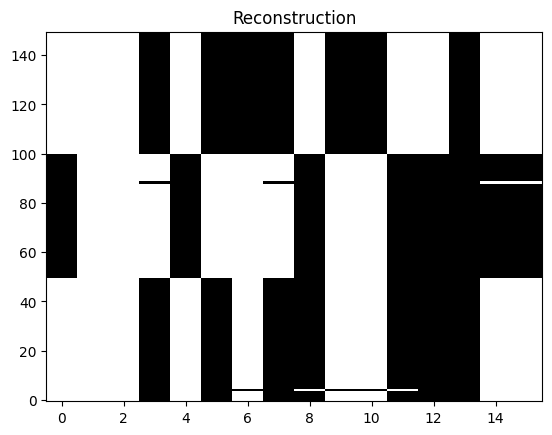

In [65]:
plt.figure()
plt.imshow(prob_on > 0.5, aspect="auto", interpolation="none", origin="lower", cmap="gray")
plt.title("Reconstruction")
plt.show()